**If you lost points on the last checkpoint you can get them back by responding to TA/IA feedback**  

Update/change the relevant sections where you lost those points, make sure you respond on GitHub Issues to your TA/IA to call their attention to the changes you made here.

Please update your Timeline... no battle plan survives contact with the enemy, so make sure we understand how your plans have changed.

# COGS 108 - EDA Checkpoint

# Names

- Ryan Lindberg
- Nathan Mitchell
- Domonick Marshall
- Sean Notolli

# Research Question

How have Amazon product prices across different market sectors changed between 2021-2024, and how do these trends compare to equivalent categories in the Consumer Price Index (CPI)? Is Amazon pricing in line with overall inflation, or does it diverge from broader economic trends?

## Background and Prior Work

Amazon has been a staple ecommerce service in many lives across the globe, bested by no other. Due to its broad market and utmost convenience, Amazon is one of the first markets considered when needing anything. However, one might wonder how costly this convenience is.

From the Amazon Product Pricing Report 2024 on Issuu <a name="cite_ref-1"></a>[<sup>1</sup>](#cite_note-1), we can see that Amazon prices are influenced by a vast amount of factors such as supply and demand, seasonal trends, competition, shifting seller fees, and algorithmic pricing. Other elements such as brand power, customer reviews, and holiday shopping behavior also contribute to pricing variability. This report serves as essential information for this project as it provides context to better interpret and analyze Amazon price trends. The report provides information on different pricing trends across different sectors of the market such as beauty, home and kitchen, arts and crafts, pet supply, and baby products, and demonstrates how each sector faces different trends. With each market sector, the report also produces concise and clear visualizations of pricing data across multiple Amazon products. 

The Consumer Price Index (CPI) Summary from the US Bureau of Labor Statistics <a name="cite_ref-2"></a>[<sup>2</sup>](#cite_note-2) offers guidance as to how to structure and analyze data related to our topic. Their report on CPI changes from 2023-2024 exemplifies how to organize large datasets and distill them into clear, actionable insights. The summary’s consistent formatting and emphasis on year-over-year percentage changes allow for a straightforward understanding of trends in consumer prices across different sectors. The structured approach will be instrumental in our own analysis of pricing data, helping us standardize our methodology and avoid potential misinterpretations. By adopting their organizational strategy, we can enhance the accuracy and credibility of our findings.

Recent research has also talked about the idea of practical implications on dynamic algorithms in pricing on market behavior. Elmaghraby and Keskinocak <a name="cite_ref-3"></a>[<sup>3</sup>](#cite_note-3) provide a review of dynamic pricing models explaining that factors like consumer demand and supply constraints drive pricing decisions in various industries. The paper talks about how algorithmic pricing is not only a tool for optimizing revenue but it can contribute to pricing volatility and competitive differences in the digital market. Using their findings with the data from Amazon product pricing report and CPI lets us understand how algorithmic strategies and external market conditions can interact with the price trends, Underscoring how important advanced computational methods are in predicting market behaviors in a retail environment.

1. <a name="cite_note-1"></a> [^](#cite_ref-1) Jungle Scout (2024, Jan). Amazon Product Pricing Report 2024. Issuu. https://issuu.com/junglescoutcobalt/docs/jungle-scout-amazon-product-pricing-report-2024?utm_source=chatgpt.html 
2. <a name="cite_note-2"></a> [^](#cite_ref-2) Bureau of Labor Statistics (2024, Feb). Consumer Price Index Summary. U.S. Department of Labor. https://www.bls.gov/news.release/pdf/cpi.html
3. <a name="cite_note-3"></a> [^](#cite_ref-3) Elmaghraby, W., & Keskinocak, P. (2003). Dynamic Pricing in the Presence of Inventory Considerations: Research Overview, Current Practices, and Future Directions. Management Science, 49(10), https://www.researchgate.net/publication/220534328_Dynamic_Pricing_in_the_Presence_of_Inventory_Considerations_Research_Overview_Current_Practices_and_Future_Directions.html



# Hypothesis


Amazon prices across different market sectors have generally increased from 2021-2024 but at an inconsistent rate with inflation trends in the consumer price index. We predict that discretionary goods like electronics and other luxury items have had smaller price increases when compared to essential goods like groceries and other necessities potentially exceeding the CPI inflation rate. We think this is due to Amazon using aggressive price matching and algorithms to remain competitive in non-essential categories where supply chain constraints and labor costs disproportionately impacted essential goods.

# Data

## Data overview

- Dataset #1
  - Dataset Name: Keepa Price Data
  - Link to the dataset: https://keepa.com/#!data
  - Number of observations: approximately 5500
  - Number of variables: 63
- Dataset #2 (if you have more than one!)
  - Dataset Name: Consumer Price Index (CPI)
  - Link to the dataset: https://www.bls.gov/cpi/tables/supplemental-files/ 
  - Number of observations: 588
  - Number of variables: 4

Keepa is a database that stores detailed information on Amazon products. By leveraging their online API, we can retrieve data segmented by price, time, product ID, and various other attributes. Additionally, we have obtained CPI data from the U.S. Bureau of Labor Statistics, allowing us to analyze average prices across different product categories over specific time periods. After cleaning and wrangling both datasets, we will be able to compare them to draw meaningful conclusions.


## Amazon Price History Dataset from Keepa API

In [5]:
# Install the keepa library (run this cell if not already installed)
#!pip install keepa

import requests
import pandas as pd
import numpy as np
import json
from pathlib import Path
import keepa
import datetime
import matplotlib.pyplot as plt
import math
import os

In [2]:
ACCESS_KEY = "df2mtauj1tmrngcm95ubshd41fplpf2bfh1nba8s8hpd2m6golbbrj9bat7osb8o" # do no share outside of private repo!!
api = keepa.Keepa(ACCESS_KEY, timeout=30)

To query the price of a given Amazon product, there are many different types of the the 'price' variable we can access. Two of them are new price and listing price. Here are the differences:

• NEW PRICE:
This is the current selling price for an item offered on Amazon in brand new condition. It reflects the actual market price that customers pay—typically the lowest available offer among Amazon and third‑party sellers. Because it’s influenced by promotions, competition, and real‑time market conditions, the NEW price can fluctuate over time.

• LISTING PRICE:
This is usually the manufacturer’s suggested retail price (MSRP) or the original price displayed on the product’s listing. It tends to be more stable and is often used as a reference to show discounts or price reductions. Even when the new price drops (for deals or competitive reasons), the listing price may remain unchanged.

The new price shows you what you’d pay right now, while the listing price is a reference value set by the manufacturer. This difference helps sellers and buyers gauge the discount depth and market dynamics.

Since we want to accurately capture the price a consumer is paying at a given time, we will use the NEW PRICE.

First, we want to gather data for a variety of Amazon products from different sectors of the market. Luckily, each product on Amazon has a unique ASIN (Amazon Standard Identification Number) which we can use to identify it. With help from the Keepa Data Product Finder tool, we can collect these ASINs along with other product information. In the following example we use the Product Finder to filter by 'product category' = grocery_and_foods, and rank = 1-1000. This finds the top 1000 items categorized under 'grocery and foods' on Amazon. Additionally we can collect the name of the product, and the sub category. We made sure to exclude variations of products, because we dont want to sample the same product 5 times just because there are 5 versions of the product with slight variations. We also refined our query to only physical products, excluding digital products and ebooks. And the final filter is 'tracking time' which allows us to only select products that have been tracked by Keepa from 2021-2024.

In [4]:
# read in top 1000 grocery products csv:
data_path = Path('data/keepa_data') / 'grocery_and_foods.csv'
products = pd.read_csv(data_path)

In [5]:
products.head(10)

,Title,Categories: Sub,ASIN
0,"CELSIUS Sparkling Strawberry Guava, Functional...","Energy Drinks, Gluten-Free Groceries, Evergree...",B08PGXDHTC
1,"Nespresso Capsules Vertuo, Voltesso, Mild Roas...","Single-Serve Capsules & Pods, Kitchen & Dining...",B0768N9N6P
2,"Premier Protein Shake, Cookies & Cream, 30g Pr...","Protein Drinks, Beverages, Protein drinks",B07MFYYZ5B
3,"Sparkling Ice, Peach Nectarine Sparkling Water...","Carbonated Water, Subscribe & Save Prime Promo...",B009S2XFVW
4,"Sparkling Ice, Cranberry Frost Sparkling Water...","Soft Drinks, Sparkling water, Sparkling Water,...",B07KY58NFX
5,"Monster Energy Zero Ultra, Sugar Free Energy D...","Energy Drinks, Subscribe & Save Prime Promo, B...",B00ADYXY7E
6,"Core Power Protein Shake, Chocolate, 26g Bottl...","Protein Drinks, Balanced Nutrition, Prime Memb...",B07LD2NV9X
7,"Starbucks K-Cup Coffee Pods, Medium Roast Coff...","Single-Serve Capsules & Pods, Packaged Coffee,...",B00U3ODTTM
8,"Nespresso Capsules Vertuo, Double Espresso Scu...","Single-Serve Capsules & Pods, Kitchen & Dining...",B07M8YV12G
9,"Nespresso Capsules VertuoLine, Hazelino Muffin...","Single-Serve Capsules & Pods, Packaged Coffee,...",B0851ZVCGL


Now that we have the ASINs, product name, and subcategory, we've noticed that many products have multiple sub categories, most of which are irrelevant for the purposes of our analysis such as "Christmas Store", "TEST ABCDEFGPD" and even random characters such as "d963aedb-8e7e-493c...". We want to remove clean the subcategory column so that each product has a single subcategory. Luckily for us, it seems that the first sub category is the most descriptive subcategory of a given product, so we can remove the others.

In [6]:
products['Categories: Sub'].value_counts().tail(10) # bottom 10 subcategories

Categories: Sub
White, Pantry, Step 3. Build your base, Gluten-Free Groceries, Plant-Based Lifestyles                                                                                                                                                                                                                                                                                                                                                                                        1
Gummy Candy, TEST ABCDEFGPD, Save 25% on Easter Candy and Gum, Back to School: Cookies & Treats, Candy & Chocolate, Featured SNAP-eligible groceries, Grocery Easter, Canned, Packaged & Baking, All Candy Coupons, Movie Night Coupons, Non-chocolate candy                                                                                                                                                                                                                 1
Peppercorns, Condiments & sauces, Pantry Staples          

In [7]:
# function remove extra subcategories from each row and rename columns
def clean_frame(df):
    df = df.rename(columns = {'Title' : 'product_title', 'Categories: Sub' : 'subcategory', 'ASIN' : 'asin'})
    def clean_row(row):
        row['subcategory'] = row['subcategory'].split(',')[0].strip().lower()
        return row
    df = df.apply(clean_row, axis = 1)
    
    return df

products = clean_frame(products)

In [8]:
products['subcategory'].value_counts().tail(10)

subcategory
baking powder    1
canola           1
bitters          1
frosting         1
chile paste      1
mixed            1
brown sugar      1
ground pepper    1
fruit            1
crackers         1
Name: count, dtype: int64

In [9]:
products['subcategory'].nunique()

229

Moving forward, we can use the ASINs column to query the Keepa API for historical price data of each item.
We define multiple functions below to achieve this:

**1. keepa_time_to_datetime(kt):**

This function takes in a keepa time integer, and converts it to standard time. Each price value has an attached time value so we know when that price was in effect

**2. def generate_monthly_headers(days):**

This function allows us to standardize which months we actually want to collect data for. When we query Keepa, it may return data from 2011 if the data is available. We dont want that data. So we can use this function to ensure that we filter the data for the months we need. It is also helpful in ensuring every time we collect data within a given range, the column headers are the same.

**3. def get_monthly_avg_prices(asins, days):**

This function gathers historical price data for a list of Amazon products using their ASINs. It returns a dataframe of the average price from the previous x amount of days for each product. We want data since 2020, so we will be using (365 * 5) for our days variable. It has some special features such as forward filling, which is helpful to fill in missing data. Since Keepa only updates prices when the price changes, and some months don't have any price changes, the natural solution is to forward fill to fill in missing data.

With our basic membership access to the Keepa API, we are limited with how much data we can request, so we will have to produce our price data in batches, and incrementally build up a large csv of price data for different product categories.

**4. def batch(iterable, n=20):**

This takes in a list of ASINs, and returns batches of them of size n.

**5. def query_keepa_in_batches(products, category, max_batches=10, batch_size=20, days=365 * 4, start_index=0, stop_index=None):**

To put it simply, this function just gets monthly avg price data for a batch of ASINs, then merges it to a master csv.

With the function query_keepa_in_batches, we can incrementally build a csv of historical price data for a given category by repeatedly requesting data from the Keepa API. The inputs to this function are: a dataframe such as grocery_and_foods, the category we are working with, i.e. the string 'grocery_and_foods', the number of batches we want, batch size, how many days of historical price data we want, and the start and stop indices of the ASINs we want to query from the dataframe. These start and stop indices allow us to pick up where we left off. So if for some reason the query stops, we can just figure out the last batch we completed, and keep going from there! If the CSV already exists, we just append to it. If it does not exist, we create a new one. This ensures we never overwrite data, and we can always keep track of where we are in the request process. This function takes many hours to run since we are limited to 1 token per minute with our API membership, and each ASIN costs 1 token. So it will have to run overnight to collect our data.

In [10]:
def keepa_time_to_datetime(kt):
    # Convert Keepa time (minutes since 2011-01-01) to a Python datetime (UTC)
    if isinstance(kt, datetime.datetime):
        return kt
    return datetime.datetime.fromtimestamp((kt + 21564000) * 60, datetime.timezone.utc)

def generate_monthly_headers(days):
    """
    Generate a list of month headers (strings) in the format 'YYYY-MM'
    spanning from the current month back to the month that includes (now - days).
    The headers are in ascending order. 2021-2025
    This function standardizes which months we collect for each batch and ensures the columns are aligned.
    """
    now = datetime.datetime.now(datetime.timezone.utc)
    start_date = now - datetime.timedelta(days=days)
    
    headers = []
    current_year = now.year
    current_month = now.month

    while True:
        header = f"{current_year:04d}-{current_month:02d}"
        headers.append(header)
        # Move to the previous month
        if current_month == 1:
            current_month = 12
            current_year -= 1
        else:
            current_month -= 1
        
        # Create a timezone-aware date for the first day of the new month.
        month_start = datetime.datetime(current_year, current_month, 1, tzinfo=datetime.timezone.utc)
        # Stop if this month is before the start_date.
        if month_start < start_date:
            break
    return sorted(headers)


def get_monthly_avg_prices(asins, days=1460):
    """
    asins: list of ASIN strings
    days: number of days of history (default 1460 ~ 4 years)
    
    Returns a DataFrame:
        - Rows = ASINs
        - Columns = monthly time periods (e.g. '2025-02', '2025-01', etc.)
        - Values = average 'NEW' price for that month
    """
    products = api.query(asins, days=days)
    dfs = []
    for product in products:
        asin = product['asin']
        price_history = product['data'].get('NEW', [])
        time_history  = product['data'].get('NEW_time', [])
        
        dates = [keepa_time_to_datetime(t) for t in time_history]
        prices = [p for p in price_history]
        
        df = pd.DataFrame({'date': dates, asin: prices})
        df.set_index('date', inplace=True)
        
        # Resample to monthly average using month-end frequency
        monthly_avg = df.resample('ME').mean()
        dfs.append(monthly_avg)
    
    if not dfs:
        return pd.DataFrame()
    
    # Combine and transpose so that rows = ASIN and columns = dates
    combined = pd.concat(dfs, axis=1).T
    # Convert datetime columns to string format 'YYYY-MM'
    combined.columns = [col.strftime('%Y-%m') for col in combined.columns]
    
    # Generate the complete set of monthly headers (headers are in descending order)
    headers = generate_monthly_headers(days)
    
    # Reindex with headers generated headers
    combined = combined.reindex(columns=headers, fill_value=np.nan)
    
    # Forward fill missing values along the row (in chronological order)
    combined = combined.ffill(axis=1)
    
    return combined


def batch(iterable, n=20):
    """Yield successive n-sized chunks from iterable."""
    for i in range(0, len(iterable), n):
        yield iterable[i:i + n]

In [ ]:
# EXAMPLE USAGE of get_monthly_avg_prices
asins = ["B009S2XFVW"]  
monthly_prices = get_monthly_avg_prices(asins, days = 365 * 4)
monthly_prices

In [11]:
def query_keepa_in_batches(products, category, max_batches=10, batch_size=20,
                           days=365 * 4, start_index=0, stop_index=None):
    """
    Query Keepa for monthly average prices in batches and incrementally save 
    the *merged* results (column-aligned) to a CSV file.
    """
    # Slice the ASIN list based on start_index and stop_index.
    asins = list(products['asin'])[start_index:stop_index]
    csv_file = f'data/asin_prices/{category}_monthly_prices.csv'
    for i, asin_batch in enumerate(batch(asins, batch_size)):
        if i >= max_batches:
            break
        df_batch = get_monthly_avg_prices(asin_batch, days=days)
        if df_batch.empty:
            print(f"Batch {i+1} returned no data; skipping.")
            continue
        # If the CSV file exists, read it, merge columns, then write back
        if os.path.exists(csv_file):
            existing_df = pd.read_csv(csv_file, index_col=0)
            
            # Merge on row index (ASIN) and combine columns (outer join).
            # combine_first() will fill missing entries in existing_df with df_batch values.
            merged_df = existing_df.combine_first(df_batch)
            
            # Ensure columns are in the correct order (descending monthly headers).
            # This step uses the same monthly headers function to reindex.
            headers = generate_monthly_headers(days)
            merged_df = merged_df.reindex(columns=headers, fill_value=np.nan)
            
            merged_df.to_csv(csv_file, index=True)
        else:
            # If no CSV yet, just write df_batch as the first chunk
            df_batch.to_csv(csv_file, index=True)
        
        print(f"Batch {i+1} processed and merged.")


# Example helper function to split the ASIN list into batches.
def batch(iterable, n=20): # 20 is default batch size
    """Yield successive n-sized chunks from iterable"""
    for i in range(0, len(iterable), n):
        yield iterable[i:i + n]

This entire process was just for the grocery and foods category. We will have to do this same process for every other product category we use. Luckily after defining all of the functions, it shouldn't be that hard. We only need to do a couple simple steps:
1. Load in a category of Amazon products as a dataframe
2. Clean the dataframe
3. Query the API to build historical price data csv. May take several hours due to token limitations.

In [169]:
# Actual use: 
category = 'grocery_and_foods'
data_path = Path('data/keepa_data') / f'{category}.csv'
grocery_and_foods = pd.read_csv(data_path)
grocery_and_foods = clean_frame(grocery_and_foods)

In [ ]:
# Actual use:
# This code may run for multiple hours. 1 minute for each product queried. 
query_keepa_in_batches(grocery_and_foods, category, max_batches=5, batch_size=20, days = (365 * 5) + 60, start_index = 900, stop_index = None)

Note:
The code of the cells above are mostly generated by ChatGPT from the prompt "How can I load the Keepa API into an ipynb, and query price data every 30 days for the past 4 years?"

Combining both dataframes:

In [13]:
category = 'grocery_and_foods'
data_path2 = Path('data/asin_prices') / f'{category}_monthly_prices.csv'
price_data = pd.read_csv(data_path2)

price_data

,Unnamed: 0,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,...,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02
0,B0000E5JIU,6.461333,6.522500,5.575000,5.575000,7.614286,7.365000,6.297500,5.572500,5.865833,...,9.386000,9.386000,9.485000,9.522727,9.011000,9.777143,9.732500,9.732500,9.817500,10.024286
1,B0001UXQ9Q,NaN,NaN,22.232500,23.864118,11.935000,11.906154,11.318182,10.860000,10.650000,...,16.285000,19.070714,11.625000,11.625000,11.625000,11.625000,12.800000,12.800000,13.796667,18.970000
2,B0002LD9IW,7.810000,5.578182,4.962500,4.032000,4.756667,4.756667,4.756667,4.756667,3.818750,...,1.353333,1.353333,1.353333,4.035000,4.035000,4.050000,4.050000,4.032000,4.032000,4.032000
3,B00032BPCM,3.847778,3.553333,7.652326,4.737206,1.565556,1.565556,1.565556,1.637500,3.287568,...,1.588947,2.105714,5.160645,4.680000,5.980000,4.951667,5.269259,5.179375,5.166667,5.057308
4,B000AXW9XI,10.208286,11.024000,11.477500,14.070645,12.530238,11.881081,11.717692,11.456486,10.265370,...,10.024706,10.461000,11.595000,17.990000,17.980556,17.970000,18.993333,19.990000,16.180000,14.240000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,B08QR1MWHF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.690000,22.180000,22.886000,19.423333,19.423333,18.924706,17.882000,18.787143,18.394444,19.733571
994,B08QTTJ1NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24.990000,24.990000,24.990000,24.990000,8.990000,14.990000,14.990000,14.990000,14.990000,14.990000
995,B08R4K3LR6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,41.980000,41.980000,46.381053,45.826667,43.594762,45.162727,45.162727,45.162727,44.874444,46.166667
996,B08R6DZXYV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.270000,13.270000,13.864000,13.864000,13.036667,13.270000,14.405000,13.130000,12.920000,12.570000


Cleaning the dataframe by rounding values to 2 decimal places and renaming column:

In [14]:
def clean_prices(df):
    # Rename 'Unnamed: 0' to 'asin'
    df = df.rename(columns={'Unnamed: 0': 'asin'})
    
    # Round every value in all columns except the first (asin) to 2 decimal places
    df.iloc[:, 1:] = df.iloc[:, 1:].round(2)
    
    return df

In [15]:
price_data = clean_prices(price_data)

Removing unnecessary columns that are out of our project scope (2021-2024):

In [16]:
cols_to_drop = list(price_data.columns[1:13]) + list(price_data.columns[-2:])
price_data = price_data.drop(columns=cols_to_drop)

Merging with other dataframe to get product title and subcategory:

In [17]:
merged_data = pd.merge(products, price_data, on='asin', how='left')

Dropping rows with no price data:

In [18]:
grocery_and_foods = merged_data.dropna(subset=merged_data.columns[4:], how='all').reset_index(drop=True)

In [19]:
grocery_and_foods

,product_title,subcategory,asin,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,...,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12
0,"CELSIUS Sparkling Strawberry Guava, Functional...",energy drinks,B08PGXDHTC,23.02,23.25,23.99,24.19,23.41,27.40,25.56,...,27.15,26.64,26.87,27.14,18.69,20.73,18.41,18.41,17.51,14.98
1,"Nespresso Capsules Vertuo, Voltesso, Mild Roas...",single-serve capsules & pods,B0768N9N6P,42.50,42.50,42.48,42.48,42.48,42.29,42.20,...,48.24,48.24,48.24,49.02,36.44,44.77,42.88,42.88,42.88,42.88
2,"Premier Protein Shake, Cookies & Cream, 30g Pr...",protein drinks,B07MFYYZ5B,22.61,22.61,22.61,26.23,21.54,16.24,21.98,...,20.93,17.14,18.28,17.95,18.24,26.43,30.98,27.59,31.69,30.03
3,"Sparkling Ice, Peach Nectarine Sparkling Water...",carbonated water,B009S2XFVW,10.18,10.18,10.18,13.32,14.41,7.84,7.84,...,15.00,12.00,11.99,11.99,11.70,15.00,13.16,15.00,14.98,14.98
4,"Monster Energy Zero Ultra, Sugar Free Energy D...",energy drinks,B00ADYXY7E,30.99,31.91,33.98,32.01,41.42,36.77,35.94,...,46.16,46.78,45.90,45.90,45.90,38.42,40.62,43.59,38.89,38.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,"BetterBody Foods Organic Refined Coconut Oil, ...",coconut,B00U1RKGOW,8.97,17.05,17.05,17.05,17.05,17.05,11.65,...,16.52,17.41,17.07,17.67,17.76,18.93,19.00,17.20,16.08,16.69
941,"Jack Link's Bacon Jerky, Hickory Smoked - Flav...",meat & seafood,B01MR6UPAQ,2.82,2.82,2.82,2.82,2.82,2.82,2.82,...,5.11,5.00,4.38,3.47,3.47,3.35,3.16,5.00,5.00,4.76
942,"Kar’s Nuts Trail Mix Variety Pack, Pack of 24 ...",snack & trail mixes,B00CPS6VTO,18.27,18.27,18.07,18.07,18.07,23.00,18.39,...,26.42,27.20,30.31,30.31,29.08,30.36,29.17,30.63,26.49,17.68
943,"Traditional Medicinals Tea, Organic Echinacea ...",herbal,B01LTI9DM2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.72,4.92,4.92,4.92,4.96,4.72,4.54,4.85,4.43,4.54


## Dataset #2 Consumer Price Index (CPI) for All Urban Consumers

### The following is a list of all separate data sets that we retreived from the CPI database.

- [All items in U.S. city average, all urban consumers, not seasonally adjusted](http://data.bls.gov/dataViewer/view/timeseries/CUUR0000SA0)
- [All items in U.S. city average, all urban consumers, seasonally adjusted](http://data.bls.gov/dataViewer/view/timeseries/CUSR0000SA0)
- [Food and beverages in U.S. city average, all urban consumers, not seasonally adjusted](http://data.bls.gov/dataViewer/view/timeseries/CUUR0000SAF)
- [Food in U.S. city average, all urban consumers, not seasonally adjusted](http://data.bls.gov/dataViewer/view/timeseries/CUUR0000SAF1)
- [Prescription drugs in U.S. city average, all urban consumers, not seasonally adjusted](http://data.bls.gov/dataViewer/view/timeseries/CUUR0000SEMF01)
- [Commodities in U.S. city average, all urban consumers, seasonally adjusted](http://data.bls.gov/dataViewer/view/timeseries/CUSR0000SAC)
- [Durables in U.S. city average, all urban consumers, seasonally adjusted](http://data.bls.gov/dataViewer/view/timeseries/CUSR0000SAD)
- [Nondurables in U.S. city average, all urban consumers, seasonally adjusted](http://data.bls.gov/dataViewer/view/timeseries/CUSR0000SAN)
- [Recreation in U.S. city average, all urban consumers, seasonally adjusted](http://data.bls.gov/dataViewer/view/timeseries/CUSR0000SAR)
- [Appliances in U.S. city average, all urban consumers, seasonally adjusted](http://data.bls.gov/dataViewer/view/timeseries/CUSR0000SEHK)
- [Toys in U.S. city average, all urban consumers, seasonally adjusted](http://data.bls.gov/dataViewer/view/timeseries/CUSR0000SERE01)
- [Apparel in U.S. city average, all urban consumers, seasonally adjusted](http://data.bls.gov/dataViewer/view/timeseries/CUSR0000SAA)
- [Baby Food and Formula in U.S. city average, all urban consumers, not seasonally adjusted](http://data.bls.gov/dataViewer/view/timeseries/CUUR0000SEFT05)
- [Non-prescription drugs in U.S. city average, all urban consumers, seasonally adjusted](http://data.bls.gov/dataViewer/view/timeseries/CUSR0000SEMF02)
- [Pets and pet products in U.S. city average, all urban consumers, not seasonally adjusted](http://data.bls.gov/dataViewer/view/timeseries/CUUR0000SERB01)
- [Living room, kitchen, and dining room furniture in U.S. city average, all urban consumers, not seasonally adjusted](http://data.bls.gov/dataViewer/view/timeseries/CUUR0000SEHJ02)
- [Tools, hardware, outdoor equipment and supplies in U.S. city average, all urban consumers, seasonally adjusted](http://data.bls.gov/dataViewer/view/timeseries/CUSR0000SEHM)
- [Jewelry and watches in U.S. city average, all urban consumers, seasonally adjusted](http://data.bls.gov/dataViewer/view/timeseries/CUSR0000SEAG)

Notes:
- Seasonally adjusted indicates that data has been statistically modified (by the CPI) to remove the effects of predictable seasonal fluctuations, like holiday shopping sprees or summer vacation trends, allowing for a clearer analysis of underlying trends without the influence of recurring seasonal patterns.
- Durables are essentially products that are designed to last a long time and be purhcased rather infrequently.
Ex: Cars, refrigerators, furniture, washing machines and dryers, musical instruments, etc.
- Nondurables are goods that are generally consumed quickly and purchased more frequently. They lose value after one use and/or after a short period of time. Ex: food, drinks, hygiene products, paper products, cosmetics, clothing items.

In [202]:
import pandas as pd

# Function to load and clean a CSV file
def load_cpi_data(filepath):
    df = pd.read_csv(filepath).drop(columns=['Series ID', 'Period'])
    df['Month'] = df['Label'].apply(lambda x: x.split()[1])
    return df.drop(columns=['Label'])[['Year', 'Month', 'Value']]

# All items in U.S. city average, all urban consumers, not seasonally adjusted
all_items_NSA = load_cpi_data('data/cpi_data/all_items_NSA.csv')

# All items in U.S. city average, all urban consumers, seasonally adjusted
all_items_SA = load_cpi_data('data/cpi_data/all_items_SA.csv')

# Food and beverages in U.S. city average, all urban consumers, not seasonally adjusted
food_and_bev = load_cpi_data('data/cpi_data/food_and_bev.csv')

# Food in U.S. city average, all urban consumers, not seasonally adjusted
food = load_cpi_data('data/cpi_data/just_food.csv')

# Prescription drugs in U.S. city average, all urban consumers, not seasonally adjusted
presc_drugs = load_cpi_data('data/cpi_data/presc_drugs.csv')

# Commodities in U.S. city average, all urban consumers, seasonally adjusted
commodities = load_cpi_data('data/cpi_data/commodities.csv')

# Durables in U.S. city average, all urban consumers, seasonally adjusted
durables = load_cpi_data('data/cpi_data/durables.csv')

# Nondurables in U.S. city average, all urban consumers, seasonally adjusted
nondurables = load_cpi_data('data/cpi_data/nondurables.csv')

# Recreation in U.S. city average, all urban consumers, seasonally adjusted
rec = load_cpi_data('data/cpi_data/recreation.csv')

# Appliances in U.S. city average, all urban consumers, seasonally adjusted
appliances = load_cpi_data('data/cpi_data/appliances.csv')

# Toys in U.S. city average, all urban consumers, seasonally adjusted
toys = load_cpi_data('data/cpi_data/toys.csv')

# Apparel in U.S. city average, all urban consumers, seasonally adjusted
apparel = load_cpi_data('data/cpi_data/apparel.csv')

# ADDING ADDITIONAL CATEGORIES TO DF - POST DATA CHECKPOINT 1

# Baby food and formula in U.S. city average, all urban consumers, not seasonally adjusted
babyff = load_cpi_data('data/cpi_data/baby_food_and_form.csv')

# Non-prescription drugs in U.S. city average, all urban consumers, seasonally adjusted
nonpresc_drugs = load_cpi_data('data/cpi_data/nonpresc_drugs.csv')

# Pets and pet products in U.S. city average, all urban consumers, not seasonally adjusted
pets_and_prods = load_cpi_data('data/cpi_data/pets_and_prods.csv')

# Living room, kitchen, and dining room furniture in U.S. city average, all urban consumers, not seasonally adjusted
home_and_kitchen = load_cpi_data('data/cpi_data/home_and_kitchen.csv')

# Tools, hardware, outdoor equipment and supplies in U.S. city average, all urban consumers, seasonally adjusted
tools_and_outdoor = load_cpi_data('data/cpi_data/tools_and_outdoor.csv')

# Jewelry and watches in U.S. city average, all urban consumers, seasonally adjusted
jewelry = load_cpi_data('data/cpi_data/jewelry.csv')

# Combine dataframes
all_cpi = pd.DataFrame({'Year': all_items_NSA['Year'], 'Month': all_items_NSA['Month']})

# Dictionary of datasets to merge
datasets = {
    'all_items_NSA': all_items_NSA, 'all_items_SA': all_items_SA, 'food_and_bev': food_and_bev,
    'food': food, 'presc_drugs': presc_drugs, 'commodities': commodities, 'durables': durables,
    'nondurables': nondurables, 'recreation': rec, 'appliances': appliances, 'toys': toys,
    'apparel': apparel, 'baby_food_and_formula': babyff, 'nonpresc_drugs': nonpresc_drugs,
    'pets_and_products': pets_and_prods, 'home_and_kitchen': home_and_kitchen,
    'tools_and_outdoor': tools_and_outdoor, 'jewelry': jewelry
}

# Add each dataset's values to `all_cpi`
for name, df in datasets.items():
    all_cpi[name] = df['Value']

all_cpi.head(10)


,Year,Month,all_items_NSA,all_items_SA,food_and_bev,food,presc_drugs,commodities,durables,nondurables,recreation,appliances,toys,apparel,baby_food_and_formula,nonpresc_drugs,pets_and_products,home_and_kitchen,tools_and_outdoor,jewelry
0,2021,Jan,261.582,262.639,270.260,270.938,525.434,189.420,107.972,230.924,122.170,81.268,28.768,119.233,172.794,95.828,202.042,89.424,92.441,176.808
1,2021,Feb,263.014,263.573,270.672,271.363,521.231,190.400,108.229,232.507,122.759,82.603,28.783,118.398,172.967,95.401,202.178,89.647,93.046,177.229
2,2021,Mar,264.877,264.847,271.135,271.812,521.375,191.908,108.754,234.155,123.192,83.148,28.944,118.481,172.045,94.911,202.372,91.781,93.636,181.111
3,2021,Apr,267.054,266.625,272.367,273.090,523.876,193.647,111.951,234.973,124.261,83.029,29.669,119.495,173.891,95.956,203.299,94.389,93.601,183.539
4,2021,May,269.195,268.404,273.441,274.212,522.116,195.923,114.749,235.969,124.605,83.705,29.402,120.612,173.949,96.139,203.247,96.370,94.921,186.720
5,2021,Jun,271.696,270.710,275.380,276.206,519.861,199.068,118.684,238.052,124.954,83.791,29.059,121.171,174.247,95.739,202.727,96.644,95.255,185.407
6,2021,Jul,273.003,271.965,277.187,278.127,519.957,200.178,119.531,239.489,125.633,84.065,29.111,121.318,176.483,95.710,205.637,94.781,95.124,184.717
7,2021,Aug,273.567,272.752,278.201,279.135,519.729,201.155,120.047,241.243,126.282,85.150,29.137,121.569,176.722,94.836,205.495,98.347,95.479,188.033
8,2021,Sep,274.310,273.942,280.452,281.506,521.506,202.684,120.120,243.527,126.521,86.230,28.775,121.124,180.697,95.743,206.448,101.761,96.124,183.854
9,2021,Oct,276.589,276.528,282.943,284.205,523.862,205.875,122.341,246.637,127.495,86.786,28.943,122.522,185.450,96.595,206.487,100.898,99.181,184.410


Melt the category columns to get the data into tidy format:

In [7]:
all_cpi = all_cpi.melt(
    id_vars=['Year', 'Month'],
    var_name='Category',
    value_name='Value'
)

In [22]:
all_cpi

,Year,Month,Category,Value
0,2021,Jan,all_items_NSA,261.582
1,2021,Feb,all_items_NSA,263.014
2,2021,Mar,all_items_NSA,264.877
3,2021,Apr,all_items_NSA,267.054
4,2021,May,all_items_NSA,269.195
...,...,...,...,...
583,2024,Sep,apparel,132.886
584,2024,Oct,apparel,131.706
585,2024,Nov,apparel,131.814
586,2024,Dec,apparel,131.986


# Results

## Exploratory Data Analysis

Carry out whatever EDA you need to for your project.  Because every project will be different we can't really give you much of a template at this point. But please make sure you describe the what and why in text here as well as providing interpretation of results and context.

## Average Percent Change by Month

Now in order to leverage out our two datasets together, we need to do a bit of data manipulation to see average percent changes per category. Doing so will help us visualiize price change over time per category. Let us first find the average percent change per month for a new grocery category with our Keepa data.


In [ ]:
# Function to tranform monthly price dataframe to a month-month percent change dataframe
def transform_perc(category):
    data_path = f'data/cleaned_keepa_data/{category}_cleaned.csv'
    df = pd.read_csv(data_path, index_col=0)
    
    ## Drop non-price columns and ensure numerical values
    df = df.iloc[:, 2:]

    ## Compute percent change column-wise using pandas 
    df = df.pct_change(axis=1,fill_method= None) * 100  # Percent change relative to previous column

    ## Change percentages to 2 decimals for tidyness
    df = df.round(2)
    return df

## Apply transformation
grocery_perc_diff = transform_perc('grocery_and_foods')
grocery_perc_diff.head(5)


,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,...,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12
product_title,,,,,,,,,,,,,,,,,,,,,
"CELSIUS Sparkling Strawberry Guava, Functional Essential Energy Drink 12 Fl Oz (Pack of 12)",NaN,1.00,3.18,0.83,-3.22,17.04,-6.72,-14.63,8.34,-22.97,...,4.34,-1.88,0.86,1.00,-31.13,10.91,-11.19,0.00,-4.89,-14.45
"Nespresso Capsules Vertuo, Voltesso, Mild Roast Espresso, 50-Count Espresso Pods, Brews 1.35oz.",NaN,0.00,-0.05,0.00,0.00,-0.45,-0.21,0.00,-0.26,0.00,...,0.00,0.00,0.00,1.62,-25.66,22.86,-4.22,0.00,0.00,0.00
"Premier Protein Shake, Cookies & Cream, 30g Protein, 1g Sugar, 24 Vitamins & Minerals, Nutrients to Support Immune Health 11.5 fl oz (12 Pack)",NaN,0.00,0.00,16.01,-17.88,-24.61,35.34,-11.69,2.47,-3.22,...,10.33,-18.11,6.65,-1.81,1.62,44.90,17.22,-10.94,14.86,-5.24
"Sparkling Ice, Peach Nectarine Sparkling Water, Zero Sugar Flavored Water, with Vitamins and Antioxidants, Low Calorie Beverage, 17 fl oz Bottles (Pack of 12)",NaN,0.00,0.00,30.84,8.18,-45.59,0.00,39.80,-17.97,-5.23,...,25.00,-20.00,-0.08,0.00,-2.42,28.21,-12.27,13.98,-0.13,0.00
"Monster Energy Zero Ultra, Sugar Free Energy Drink, 16 Ounce, Pack of 24",NaN,2.97,6.49,-5.80,29.40,-11.23,-2.26,3.70,-17.84,-6.24,...,2.51,1.34,-1.88,0.00,0.00,-16.30,5.73,7.31,-10.78,0.00


Let's take a look at the percent change over time of the popular energy drink CELSIUS.

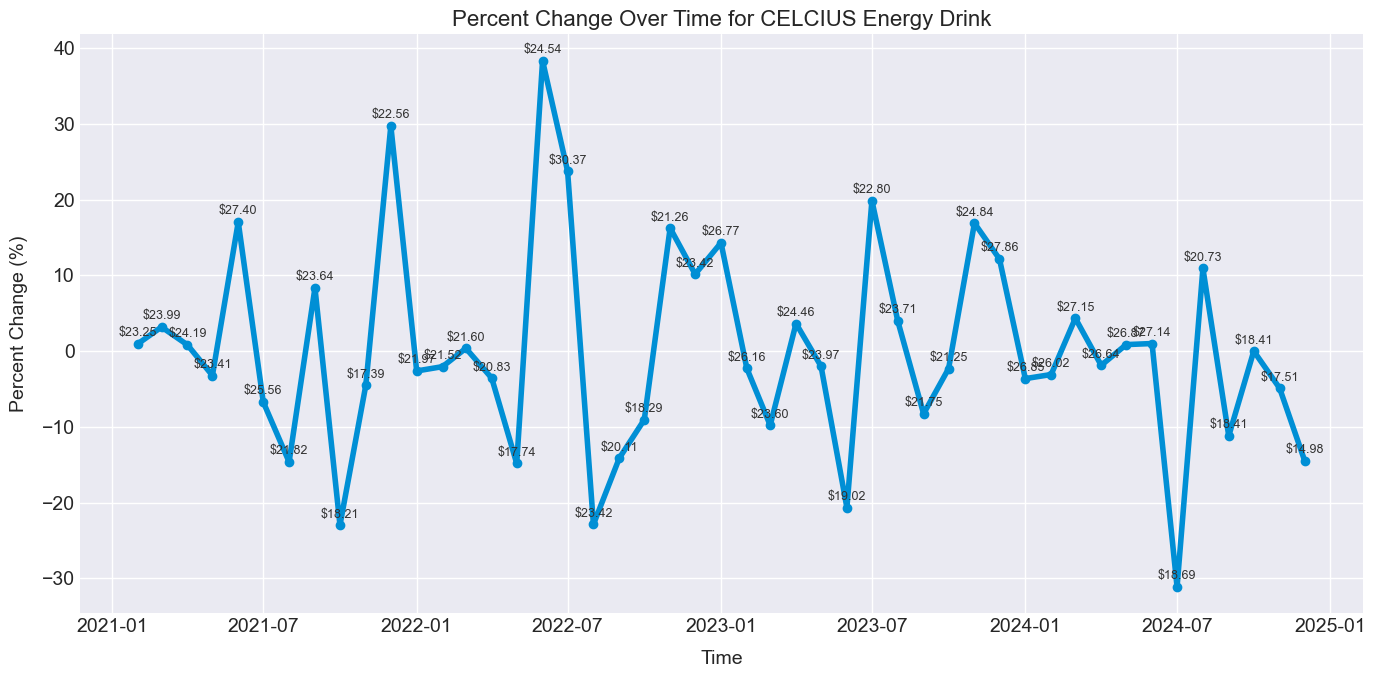

In [ ]:
# Slice off first column with NaN values
percent_change = grocery_perc_diff.iloc[0, 1:]

# Extract price values for CELSIUS energy drink
price_values = grocery_and_foods.iloc[0, 3:].values  

# Convert columns to datetime
dates = pd.to_datetime(grocery_perc_diff.columns, format="%Y-%m")

plt.style.use('seaborn-v0_8-darkgrid')

# Define plot
fig, ax = plt.subplots(figsize=(14, 7))

# Plot percent change
ax.plot(dates[1:], percent_change, marker='o')

# Annotate each point with  prices
for i, (date, y) in enumerate(zip(dates[1:], percent_change)):
    price = price_values[i + 1] 

    if not pd.isna(price):
        ax.text(date, y + 1, f"${price:.2f}", fontsize=9, ha='center', color='#333')

ax.set_xlabel("Time", fontsize=14, fontweight='medium', labelpad=10)
ax.set_ylabel("Percent Change (%)", fontsize=14, fontweight='medium', labelpad=10)
ax.set_title("Percent Change Over Time for CELCIUS Energy Drink", fontsize=16, fontweight='medium')

plt.tight_layout()
plt.show()

We can see that CELSIUS's price increased the most during June of 2022. This could be for many reasons such supply and demand, seasonal trends, competition, shifting seller fees, and/or Amazons algorithmic pricing. Later on, we would like to use a similar strategy to identify if products like this follow any inflationary trends measured in the Consumer Price Index data.

Now, we will call the percent difference transformation function the remainder of our Keepa categories.

In [103]:
appliances_perc_diff = transform_perc('appliances')
baby_products_perc_diff = transform_perc('baby_products')
beauty_and_personal_care_perc_diff = transform_perc('beauty_and_personal_care')
clothing_shoes_and_jewelry_perc_diff = transform_perc('clothing_shoes_and_jewelry')
electronics_diff = transform_perc('electronics')
health_and_household_perc_diff = transform_perc('health_and_household')
home_and_kitchen_perc_diff = transform_perc('home_and_kitchen')
pet_supplies_perc_diff = transform_perc('pet_supplies')
toys_perc_diff = transform_perc('toys')

One thing we're sure of is that toilet paper was in high demand during the covid era. Since we dont have data for 2020, we may not see this effect, but its worth investigating. Lets see look at toilet paper data we collected from Amazon in the the health_and_household category.

In [144]:
toilet_paper_perc_diff = health_and_household_perc_diff.loc[
    health_and_household_perc_diff.index.str.contains('Toilet Paper', case=False, na=False)
]
data_path = f'data/cleaned_keepa_data/health_and_household_cleaned.csv'
toilet_paper_prices = pd.read_csv(data_path, index_col=0)
toilet_paper_prices = toilet_paper_prices.loc[
    health_and_household_perc_diff.index.str.contains('Toilet Paper', case=False, na=False)
]
toilet_paper_prices

,subcategory,asin,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,...,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12
product_title,,,,,,,,,,,,,,,,,,,,,
"Scott ComfortPlus Toilet Paper, 12 Double Rolls, 231 Sheets per Roll, Septic-Safe, 1-Ply Toilet Tissue",toilet paper,B07BGLT25K,15.46,21.88,18.25,17.31,15.67,16.91,16.20,16.36,...,5.99,5.99,5.99,5.99,5.99,5.81,9.54,9.22,6.22,6.30
"Charmin Ultra Soft Cushiony Touch Toilet Paper, 24 Family Mega Rolls = 123 Regular Rolls",toilet paper,B0798DVT68,37.96,33.11,31.42,28.59,27.01,23.33,23.05,20.23,...,35.25,32.99,33.30,34.62,35.49,37.41,29.71,35.11,35.11,34.79
"Cottonelle Ultra Clean Toilet Paper with Active CleaningRipples, 1- Ply, 24 Family Mega Rolls (4 Packs of 6) (24 Family Mega Rolls= 132 Regular Rolls), 388 Sheets per Roll, Packaging May Vary",toilet paper,B07ND5BB8V,24.37,24.00,24.00,25.18,21.66,19.76,15.36,15.70,...,26.21,40.36,37.43,31.30,31.48,37.65,36.89,42.12,36.50,36.48
"Scott 1000 Toilet Paper, 8 Rolls, Septic-Safe, 1-Ply Toilet Tissue",toilet paper,B00O93GHO2,17.97,16.38,18.67,14.32,19.31,20.95,16.84,20.89,...,11.93,11.93,14.31,10.84,9.98,9.92,9.99,10.44,10.51,10.50
"Cottonelle Ultra Comfort Toilet Paper with Cushiony CleaningRipples, 2- Ply, 24 Family Mega Rolls (4 Packs of 6) (24 Family Mega Rolls= 108 Regular Rolls), 325 Sheets per Roll, Packaging May Vary",toilet paper,B07ND3MW45,24.24,39.11,39.11,24.59,17.00,17.03,17.47,18.91,...,35.75,32.37,30.19,30.09,30.17,37.50,33.59,38.25,35.72,35.84
"Quilted Northern Ultra Plush 3-ply Toilet Paper, Mega Rolls, 6 Count (Pack of 1)",toilet paper,B010OVIO9I,10.00,9.87,10.19,8.74,10.12,10.67,10.50,11.19,...,17.19,15.90,14.29,14.19,15.72,17.23,16.57,16.32,16.20,16.20
"Quilted Northern Ultra Soft & Strong Toilet Paper, 24 Mega Rolls = 96 Regular Rolls, 2-ply Bath Tissue, White",toilet paper,B0854W9JWZ,27.42,36.13,36.13,36.13,39.73,34.29,28.74,27.13,...,23.84,23.78,23.72,23.69,31.61,40.40,40.76,44.12,41.89,41.69
"Scott Rapid-Dissolving Toilet Paper, 48 Double Rolls (6 Packs of 8), Sustainable, Septic-Safe, Toilet Paper",toilet paper,B08M2LCMQF,34.12,34.12,34.12,72.73,75.18,39.85,39.48,48.46,...,50.09,50.09,50.09,50.09,37.10,37.99,37.92,38.35,35.29,35.29
"Charmin Ultra Strong Toilet Paper, 18 Super Mega Rolls = 108 Regular Rolls",paper & plastic,B0741DT22M,32.92,37.41,38.31,40.13,48.78,25.92,25.92,24.45,...,30.06,34.73,28.87,28.81,29.28,29.66,29.15,44.12,40.06,38.16


This should be good enough for our small investigation. Lets average out these columns and visualize the price changes in toilet paper products.

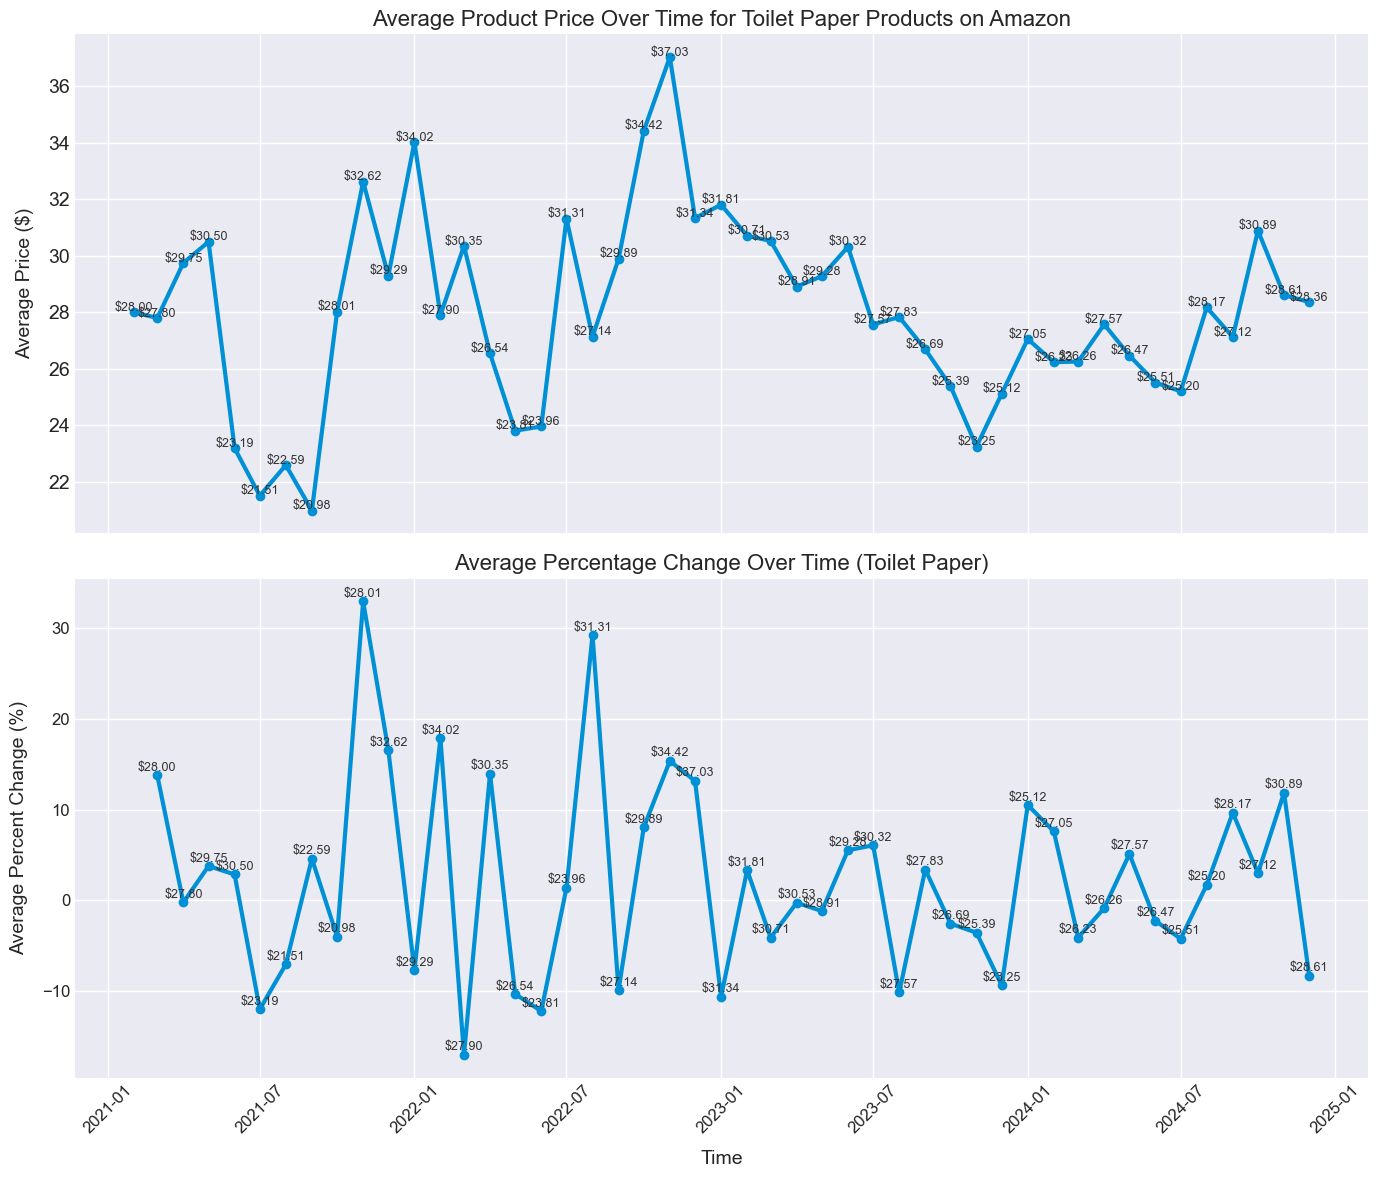

In [ ]:
# Extract numeric price columns
price_data = toilet_paper_prices.iloc[:, 3:].apply(pd.to_numeric, errors='coerce')

# Calculate average price per month column-wise
avg_price_values = price_data.mean(axis=0, skipna=True)

# Compute column-wise average percentage change
avg_percent_change = toilet_paper_perc_diff.mean(axis=0, skipna=True)

# Convert columns to datetime
dates = pd.to_datetime(price_data.columns, format="%Y-%m")

# Ensure avg_percent_change has the same length as dates[1:]
avg_percent_change = avg_percent_change.iloc[1:len(dates)].reset_index(drop=True)

plt.style.use('seaborn-v0_8-darkgrid')

## Create figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 12), sharex=True)

## Plot average price over time
axes[0].plot(dates, avg_price_values, marker='o', linestyle='-', linewidth=3, markersize=6, color='#0090d6')
axes[0].set_ylabel("Average Price ($)", fontsize=14, fontweight='medium', labelpad=10)
axes[0].set_title("Average Product Price Over Time for Toilet Paper Products on Amazon", fontsize=16, fontweight='medium')

## Annotate average prices
for x, y in zip(dates, avg_price_values):
    if not pd.isna(y):
        axes[0].text(x, y + 0.05, f"${y:.2f}", fontsize=9, ha='center', color='#333')


# Plot 2
## Plot average percentage change over time
axes[1].plot(dates[1:], avg_percent_change, marker='o', linestyle='-', linewidth=3, markersize=6, color='#0090d6')
axes[1].set_xlabel("Time", fontsize=14, fontweight='medium', labelpad=10)
axes[1].set_ylabel("Average Percent Change (%)", fontsize=14, fontweight='medium', labelpad=10)
axes[1].set_title("Average Percentage Change Over Time (Toilet Paper)", fontsize=16, fontweight='medium')

## Annotate average prices 
for i, (date, y) in enumerate(zip(dates[1:], avg_percent_change)):
    price = avg_price_values.iloc[i]  # Offset by 1 to match percent change index
    if not pd.isna(price):
        axes[1].text(date, y + 0.5, f"${price:.2f}", fontsize=9, ha='center', color='#333')

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


### Why were toilet paper prices so high in late 2022 - early 2023?

As it turns out, with a little investigation, an [LA Times article](https://www.latimes.com/business/story/2023-02-10/housing-market-making-toilet-paper-more-expensive) from February 2023 shows that this price spike is likely due to a housing market slump in the US during this time, which led to lumber prices increasing, which led to toilet paper prices increasing! Super interesting.

 It looks like Amazon prices do reflect overall trends in the market. This a great example of an external shcok, which third party events have had an impact on supply chains and prices.


##### Next, lets try taking a look at a correlation matrix for subcategories.
This is important because if two categories are high in correlation it, implies that they share similar pricing influence due to other factors such as supply chain or related consumer habits.

This will help us understand if said categories are reacting to similar extnernal market pressures, or if they behave unqiquely.

In [188]:
data_path = f'data/cleaned_keepa_data/grocery_and_foods_cleaned.csv'
grocery_and_foods = pd.read_csv(data_path, index_col=0)
grocery_and_foods.iloc[:, 2:]= grocery_and_foods.iloc[:, 2:].pct_change(axis=1,fill_method= None) * 100  # Percent change relative to previous column
grocery_and_foods = grocery_and_foods.round(2)


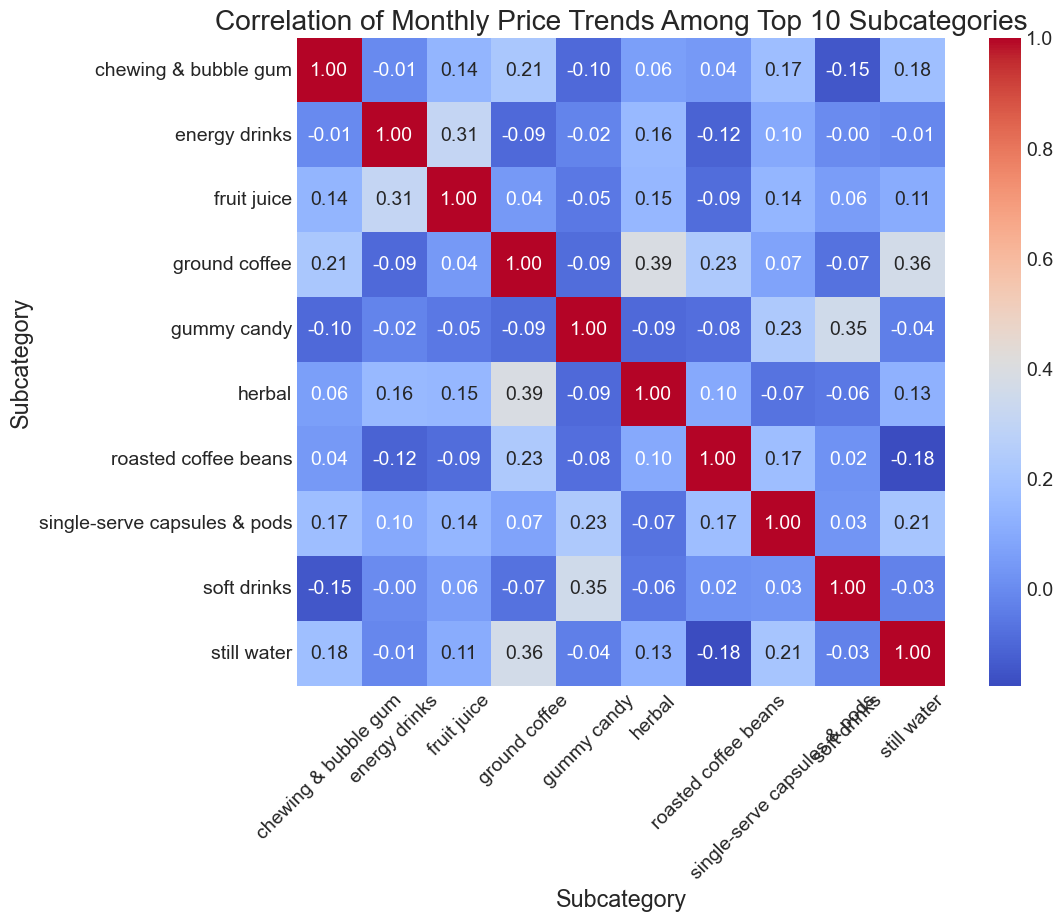

In [ ]:
# Top 10 most frequent subcategories
top_subcategories = grocery_and_foods['subcategory'].value_counts().iloc[:10].index

# Ensure only numeric columns are used
monthly_prices_top = grocery_and_foods[grocery_and_foods['subcategory'].isin(top_subcategories)]
monthly_prices_top = monthly_prices_top.groupby('subcategory').mean(numeric_only=True)

# Remove non-numeric columns
monthly_prices_top = monthly_prices_top.select_dtypes(include=['number'])

# Transpose so we get subcategories as columns and months as rows
monthly_prices_top = monthly_prices_top.T

# Compute the correlation matrix
correlation_matrix_top = monthly_prices_top.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_top, annot=True, cmap="coolwarm", fmt=".2f", square=True)

plt.title("Correlation of Monthly Price Trends Among Top 10 Subcategories")
plt.xlabel("Subcategory")
plt.ylabel("Subcategory")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


Now, lets move on to transforming our CPI data sets starting with the food and beverages category.

In [27]:
food_and_bev.head(5)

,Year,Month,Value
0,2021,Jan,270.260
1,2021,Feb,270.672
2,2021,Mar,271.135
3,2021,Apr,272.367
4,2021,May,273.441


As shown, our CPI and Keepa data do not have the same format which would might lead to issues with plotting later on. Both the time periods and values are columns. Let's define a function, "style_transform", to transform our CPI data into the same columns as dates format as our Keepa Data.

In [ ]:
# Redefine the percentage transform function to take care of the new CPI without assigning a path
def cpi_perc(df):
    df = df.pct_change(axis=1) * 100  ## Calculate percentage difference across columns
    df.iloc[:, 0] = 0  ## Set first column to 0 (since there's no previous month)
    return df.round(2)  ## Round to 2 decimal places for tidiness

def style_transform(df):
    month_to_num = {
        'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06',
        'Jul': '07', 'Aug': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'
    }
    df['Year-Month'] = df['Year'].astype(str) + '-' + df['Month'].map(month_to_num)

    df_changed = df.pivot_table(columns='Year-Month', values='Value')

    df_changed = df_changed.reset_index(drop=True)
    return df_changed

## Transform our food_and_bev dataframe
food_and_bev_perc = style_transform(food_and_bev)
food_and_bev_perc = cpi_perc(food_and_bev_perc)
food_and_bev_perc.head()

Year-Month,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,...,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01
0,0.0,0.15,0.17,0.45,0.39,0.71,0.66,0.37,0.81,0.89,...,0.19,0.13,0.18,0.25,0.06,0.38,0.19,0.06,0.17,0.57


This is now the same format as our Keepa data. Let's transform the rest of our CPI dataframes, and then apply our percentage transformation 

In [192]:
apparel = style_transform(apparel)
apparel_perc = cpi_perc(apparel)
appliances = style_transform(appliances)
appliances_perc = cpi_perc(appliances)
commodities = style_transform(commodities)
commodities_perc = cpi_perc(commodities)
durables = style_transform(durables)
durables_perc = cpi_perc(durables)
nondurables = style_transform(nondurables)
nondurables_perc = cpi_perc(nondurables)
presc_drugs = style_transform(presc_drugs)
presc_drugs_perc = cpi_perc(presc_drugs)
rec = style_transform(rec)
rec_perc = cpi_perc(rec)
toys = style_transform(toys)
toys_perc = cpi_perc(toys)

### Now, we can start leveraging both datasets together!

TODO:

See if we can calculate inflation adjusted prices for the keepa dataframes.
Use a dual axis line plot to plot both CPI and Amazon data side by side. 


### Section 2 of EDA if you need it  - please give it a better title than this

Some more words and stuff.  Remember notebooks work best if you interleave the code that generates a result with properly annotate figures and text that puts these results into context.

In [ ]:
## YOUR CODE HERE
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION

# Ethics & Privacy

- Thoughtful discussion of ethical concerns included
- Ethical concerns consider the whole data science process (question asked, data collected, data being used, the bias in data, analysis, post-analysis, etc.)
- How your group handled bias/ethical concerns clearly described
- Discussed the main points of Deon’s Ethics Checklist in a meeting together. Reviewed each section as a team before submission. 

Acknowledge and address any ethics & privacy related issues of your question(s), proposed dataset(s), and/or analyses. Use the information provided in lecture to guide your group discussion and thinking. If you need further guidance, check out [Deon's Ethics Checklist](http://deon.drivendata.org/#data-science-ethics-checklist). In particular:

- Are there any biases/privacy/terms of use issues with the data you propsed?
    - If we decide to use an API to collect our Amazon pricing data such as Keepa, we intend to comply with the Keepa data security policies and API terms of service. 
- Are there potential biases in your dataset(s), in terms of who it composes, and how it was collected, that may be problematic in terms of it allowing for equitable analysis? (For example, does your data exclude particular populations, or is it likely to reflect particular human biases in a way that could be a problem?)
    - If we decide to use an API to collect our Amazon pricing data such as Keepa, we intend to comply with the Keepa data security policies and API terms of service. 
- How will you set out to detect these specific biases before, during, and after/when communicating your analysis?
    - We will start in the data collection process, and ensure that we are collecting data in an unbiased way to effectively represent the Amazon markets while also focusing on aligning these samples with CPI sectors fairly. After we have collected the data, we will conduct EDA to ensure that we did not miss any potential biases in the data collection process. 
- Are there any other issues related to your topic area, data, and/or analyses that are potentially problematic in terms of data privacy and equitable impact?
    - We want to make it clear that regardless of our findings, we are only establishing a correlation between Amazon product prices and CPI rates, and not a causal relationship. Any results are not conclusive evidence that Amazon is responsible for any part of inflation in the US. If our analysis is misinterpreted, it could lead to false narratives about Amazon’s role in inflation. We intend to frame conclusions carefully and provide balanced interpretations of our results. 
- Personally Identifiable Information
    - No personally identifiable information will be collected. However, some sellers may be identifiable, especially if analyzing price trends for specific brands or niche categories. Seller information will be removed and/or hidden from our analysis.
- Metric Selection:
    - Use percentage price change instead of raw price differences, ensuring fair comparisons across categories.
- Explainability:
    - Clearly explain findings to avoid speculative claims about Amazon's role in inflation, labor costs, price matching, etc.
- Communication Limitation:
    - Highlight that CPI and Amazon prices are not perfect comparisons, and results should be interpreted with caution.
- Transparency: 
    - Since access to Keepa data requires a paid membership, it reduces transparency and reproducibility for others who may want to replicate the study. To mitigate this, we minted to provide detailed documentation on how the data was obtained and which filters were applied.

# Team Expectations 


* *Meet twice a week, Friday at 5pm and Wednesdays around 8:30pm.*

* *Delegate work as we see fit in order to meet deadlines, no one group member has one specific role, all types of work will be shared.*

* *Openness to ideas. Be respectful and kind to each other if there is disagreement.*

* *Meeting primarily on zoom, and keeping consistent communication when not meeting via a group chat (iMessage)*

* *Allow space for input and opinions from all members, and come to decisions about our course of action unanimously. Discuss conflicts and ideas until each member feels comfortable with the final decision.*

* *If there is an pressing outside factor (personal life, exams, etc.) communicate with each other and find another course of action, work can be delegated differently if need be.*

# Project Timeline Proposal


| Meeting Date  | Meeting Time| Completed Before Meeting  | Discuss at Meeting |
|---|---|---|---|
| 2/07  |  5 PM | Brainstorm Topics / Review Project Proposal  | Finalize a topic and start searching for datasets | 
| 2/09  |  8:30 PM |  N/A | Discuss amongst eachother goals for the project and review/submit research proposal | 
| 2/12  | 8:30 PM  | Search for any more possible Datasets  | Discuss how to divvy up our project and make a broad outline   |
| 2/14  | 5 PM  | Import our Datasets and start wrangling | Review/Edit wrangling/EDA; Discuss Analysis Plan   |
| 2/21  | 5 PM  | Finalize wrangling/EDA; Begin Analysis | Discuss/edit Analysis; Finish Ceck in #1 |
| 3/7  |  5 PM  | Complete analysis; Draft results/conclusion/discussion (Wasp)| Discuss/edit full project ; Check in #2 - Complete EDA |
| 3/14  | 5 PM  | Practice Video Presentation | Record our Project Presentation |
| 3/19  | 5 PM  | Go over each section of our Project | Finialize Files and Submit |